In [77]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model


In [39]:
data = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'hedge_fund_series')
data.set_index('date',inplace=True)
Y = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'merrill_factors')
Y.set_index('date',inplace=True)

SPY = Y['SPY US Equity']
data['SPY'] = SPY


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY
date,,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006491,-0.054976
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142,-0.069449
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025241,0.109147
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965,-0.004064
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001854,0.010440
...,...,...,...,...,...,...
2021-05-31,0.013401,0.000701,0.000666,-0.000784,0.005940,0.006566
2021-06-30,0.005424,0.005985,0.005991,0.001052,0.002485,0.022473
2021-07-31,-0.009095,-0.013890,-0.013766,-0.012520,-0.003409,0.024412


In [97]:
def performanceMetrics(returns):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean()  * 12
    metrics['Vol'] = returns.std() * np.sqrt(12)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(12)

    return metrics

metrics = performanceMetrics(data)
metrics

,Mean,Vol,Sharpe
HFRIFWI Index,0.050784,0.061507,0.825665
MLEIFCTR Index,0.038821,0.053848,0.720933
MLEIFCTX Index,0.037330,0.053682,0.695382
HDG US Equity,0.028100,0.056380,0.498407
QAI US Equity,0.025491,0.045484,0.560434
SPY,0.147548,0.135363,1.090019


In [99]:
def tailRisk(returns):
    metrics = pd.DataFrame(index = returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis() - 3
    metrics['VaR (5th)'] = returns.quantile(.05)
    metrics['CVaR (5th)'] = (returns[returns < returns.quantile(.05)]).mean()
    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    
    return metrics

tailRisk(data)

,Skewness,Kurtosis,VaR (5th),CVaR (5th),Min,Max
HFRIFWI Index,-1.109248,3.730109,-0.025311,-0.038757,-0.090784,0.058602
MLEIFCTR Index,-0.186692,-0.570516,-0.025527,-0.032779,-0.053234,0.058886
MLEIFCTX Index,-0.171632,-0.624403,-0.025629,-0.032724,-0.052384,0.058805
HDG US Equity,-0.179641,-0.418346,-0.028529,-0.034782,-0.059191,0.058304
QAI US Equity,-0.545085,-0.330447,-0.016172,-0.026348,-0.056346,0.034138
SPY,-0.394559,-1.437449,-0.060906,-0.079288,-0.124642,0.126984


In the sample code, 3 was subtracted from the kurtosis function output. In the code showcased in the lecture yesterday, 3 was not subtracted. I will submit it with 3 subtracted. 

In [96]:
def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()    
    summary = pd.DataFrame({'Max Drawdown':max_drawdown, 'Bottom':end_date})
    
    
    # The rest of this code is to get the peak and Recover dates.
    # It is tedious, and I recommend skipping the rest of this code unless you are 
    # already comfortable with Python and Pandas.
    
    # get the date at which the return recovers to previous high after the drawdown
    summary['Recover'] = None
    for col in returns.columns:
        idx = returns.index[(returns.index >= end_date[col]).argmax()]
        check_recover = (cum_returns.loc[idx:,col] > rolling_max.loc[idx,col])
        if check_recover.any():                
            summary.loc[col,'Recover'] = check_recover.idxmax()            
    summary['Recover'] = pd.to_datetime(summary['Recover'])

    
    # get the date at which the return peaks before entering the max drawdown
    summary.insert(loc=1, column='Peak',value=0)
    for col in returns.columns:
        df = rolling_max.copy()[[col]]
        df.columns=['max']
        df['max date'] = df.index
        df = df.merge(df.groupby('max')[['max date']].first().reset_index(), on='max')
        df.rename(columns={'max date_y': 'max date', 'max date_x': 'date'}, inplace=True)
        df.set_index('date',inplace=True)

        summary.loc[col,'Peak'] = df.loc[end_date[col],'max date']

    summary['Peak'] = pd.to_datetime(summary['Peak'])
    summary['Peak to Recover'] = (summary['Recover'] - summary['Peak'])
        
    return summary

maximumDrawdown(data)

,Max Drawdown,Peak,Bottom,Recover,Peak to Recover
HFRIFWI Index,-0.115473,2019-12-31,2020-03-31,2020-08-31,244 days
MLEIFCTR Index,-0.084500,2019-12-31,2020-03-31,2020-11-30,335 days
MLEIFCTX Index,-0.083673,2019-12-31,2020-03-31,2020-11-30,335 days
HDG US Equity,-0.088245,2020-01-31,2020-03-31,2020-11-30,304 days
QAI US Equity,-0.075649,2019-12-31,2020-03-31,2020-07-31,213 days
SPY,-0.194266,2019-12-31,2020-03-31,2020-07-31,213 days


In [26]:
Y = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'merrill_factors')

In [100]:
def get_ols_metrics(regressors,targets,annualization=1):
    
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors,pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets,pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors,how='inner',lsuffix='y ')
    Y = df_aligned[targets.columns]
    X = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        model = LinearRegression().fit(X,y)
        reg.loc[col,'alpha'] = model.intercept_ * annualization
        reg.loc[col,regressors.columns] = model.coef_
        reg.loc[col,'r-squared'] = model.score(X,y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit    
        reg.loc[col,'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

mkt = get_ols_metrics(data['SPY'],data,annualization=12)
mkt['Treynor'] = metrics['Mean'] / mkt['SPY']
mkt = mkt.head(-1)
mkt

<ipython-input-100-d0d92eba9a3b>:25: RuntimeWarning: invalid value encountered in double_scalars
  reg.loc[col,'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)


,alpha,SPY,r-squared,Info Ratio,Treynor
HFRIFWI Index,-0.007397,0.394320,0.753090,-0.242025,0.128789
MLEIFCTR Index,-0.014205,0.359382,0.816158,-0.615265,0.108021
MLEIFCTX Index,-0.015497,0.358034,0.815047,-0.671268,0.104263
HDG US Equity,-0.026375,0.369199,0.785733,-1.010612,0.076111
QAI US Equity,-0.016560,0.284993,0.719379,-0.687283,0.089443


4.

Note that the intercept is annualized. Clearly, SPY and the multiple series have a positive linear relationship. The R squared values are all above .7, which means at least 70% of the variation is explained through the regression. In general, all performed worse than the SPY, as the alpha values are all below zero. 

Between HDG and QAI, the beta for HDG is greater, which means that the overall change in HDG given a one unit increase in SPY is greater than the change found in QAI. There is a notable discrepancy, as HDG has a more negative information ratio and a smaller Treynor ratio. With that mind, it may seem that QAI performs better when keeping the elements of risk in mind. 

The HDG and ML series do seem to capture most of the notable properties of the HFRIFWI Index. The beta values are very similar, and the R squared is above 78% for all of them. Because the alpha and beta values are somewhat similar, general shifts in SPY will result in similar shifts in HDG, MLE, and HFRIFWI. I would say that the HDG and the ML series capture the most notable properties of HFRI. 

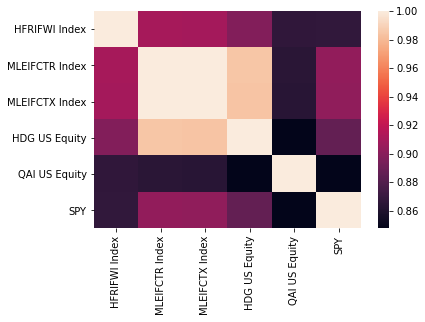

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY
HFRIFWI Index,1.000000,0.910392,0.910063,0.897653,0.866714,0.867808
MLEIFCTR Index,0.910392,1.000000,0.999939,0.984621,0.864431,0.903415
MLEIFCTX Index,0.910063,0.999939,1.000000,0.984471,0.863734,0.902799
HDG US Equity,0.897653,0.984621,0.984471,1.000000,0.847597,0.886416
QAI US Equity,0.866714,0.864431,0.863734,0.847597,1.000000,0.848162
SPY,0.867808,0.903415,0.902799,0.886416,0.848162,1.000000


In [98]:
datacor = data.corr()
ax = sns.heatmap(datacor)
plt.show()
datacor

The highest correlation seems to be found between the ML Factor Model and the ML Factor Model X. Apart from that, the next highest correlation can be found between "PROSHARES HEDGE REPLICAT ETF"and the ML Factor Model X. The lowest correlation can be found between QAI US Equity and HDG US Equity: 0.847. 

In [106]:
X = Y[['SPY US Equity','USGG3M Index', 'EEM US Equity', 'EFA US Equity', 'EUO US Equity', 'IWM US Equity']]
X
yy = data['HFRIFWI Index']

regr = linear_model.LinearRegression()
model = regr.fit(X, yy)

print(regr.coef_)
model.score(X, yy)
residuals = yy - model.predict(X)
model.intercept_ * 12
residuals.std() * np.sqrt(12)


[ 0.07202237 -0.40059141  0.0721592   0.10631807  0.02243061  0.13089205]


0.023365015548091676

$$\hat{\alpha} = 0.013760384058106326 \text{(annualized)}$$
$$\hat{\beta_1} = 0.07202237 $$
$$\hat{\beta_2} = -0.40059141 $$
$$\hat{\beta_3} = 0.0721592$$
$$\hat{\beta_4} = 0.10631807$$
$$\hat{\beta_5} = 0.02243061$$
$$\hat{\beta_6} = 0.13089205 $$

$$\hat{r_t} =  \hat{\alpha} + \hat{\beta_1} * \text{SPY} + \hat{\beta_2} * \text{USGG3M} + \hat{\beta_3} * \text{EEM} + \hat{\beta_4} * \text{EFA} + \hat{\beta_5} * \text{EUO} + \hat{\beta_6} * \text{IWM}$$

The non-estimated equation is the same; just remove the "hats" and add the error term. The betas are relatively reasonable: there are no short positions that require a >15% short, and the only positive positions is below 0.4. The betas do not require unreasonable long-short positions: for every dollar invested, you will be hedging less than a dollar overall. That sounds reasonable.

$$R^2 = 0.8556947723602492$$
$$ \text{annualized volatility of } \epsilon^{merr} = 0.023365015548091676$$